In [ ]:
!pip install pyspark

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, functions as F
from pyspark import SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.sql.functions import col, when, udf
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel, GBTClassifier, RandomForestClassifier, RandomForestClassificationModel, GBTClassificationModel, MultilayerPerceptronClassifier, MultilayerPerceptronClassificationModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Needed to calculate arr delay later
def to_minutes(hhmm):
    hours = int(hhmm // 100)
    minutes = int(hhmm % 100)
    return hours * 60 + minutes

In [ ]:
spark_s = SparkSession.builder \
    .appName("Flight Data Analysis") \
    .getOrCreate()
#df = spark_s.read.option("delimiter", ",").csv("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/flights_sample_3m.csv", header=True, inferSchema=True)

to_minutes_udf = udf(to_minutes, IntegerType())

**PART 1: STUDYING THE DATASET**

This part concerns itself with EDA and the preliminary dataset studies.
SKIP THIS PART TO GO TO DATASET PREPROCESSING AND ML ALGORITHMS.

In [ ]:
df.show(n=20, truncate=False)
df.describe().show()
N = df.count()
print(f"Total number of rows: {N}")

+----------+----------------------+--------------------------+------------+--------+---------+------+----------------------+----+---------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|FL_DATE   |AIRLINE               |AIRLINE_DOT               |AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|ORIGIN_CITY           |DEST|DEST_CITY            |CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+----------+----------------------+--------------------------+------------+--------+---------+------+----------------------+----+-------

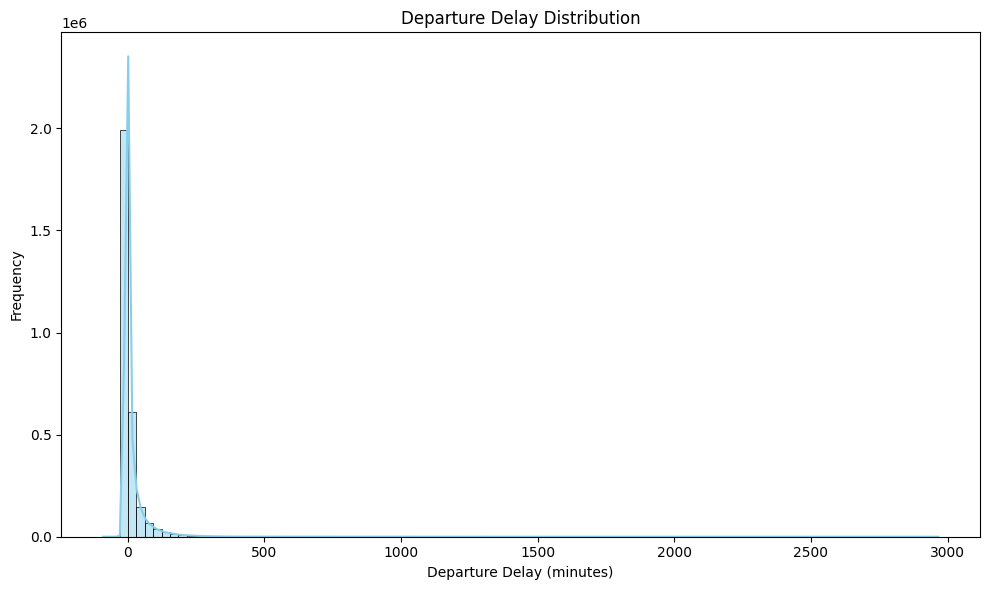

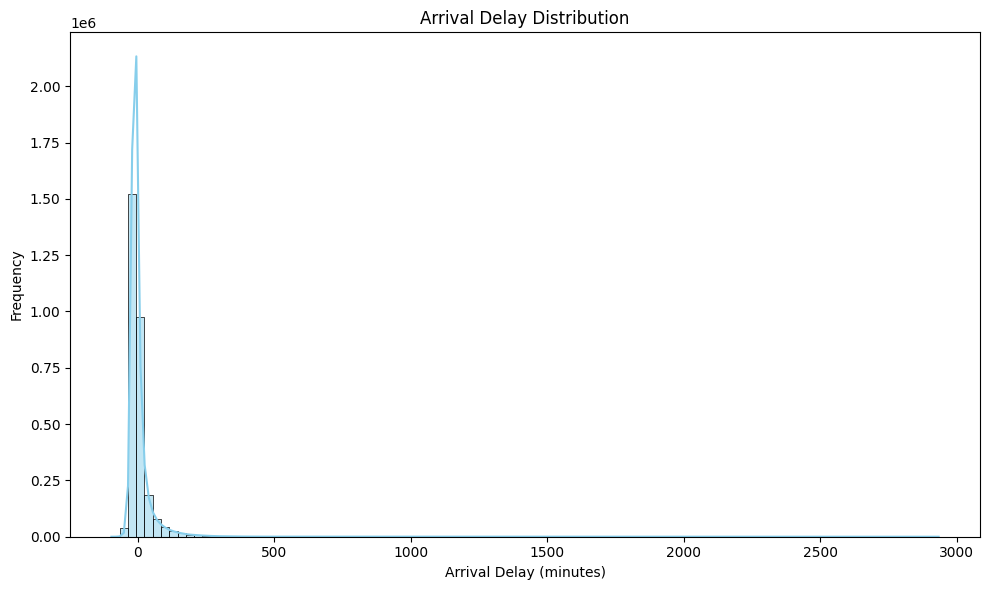

In [ ]:
#Plot distributions of the delay information
dep_delay_df = df.select("DEP_DELAY").toPandas()
dep_delay_df = dep_delay_df.dropna()
plt.figure(figsize=(10, 6))
sns.histplot(dep_delay_df['DEP_DELAY'], kde=True, color='skyblue', bins=100)
plt.title('Departure Delay Distribution')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("./Departure_Delay_Distribution.png")
plt.show()

arr_delay_df = df.select("ARR_DELAY").toPandas()
arr_delay_df = arr_delay_df.dropna()
plt.figure(figsize=(10, 6))
sns.histplot(arr_delay_df['ARR_DELAY'], kde=True, color='skyblue', bins=100)
plt.title('Arrival Delay Distribution')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("./Arrival_Delay_Distribution.png")
plt.show()

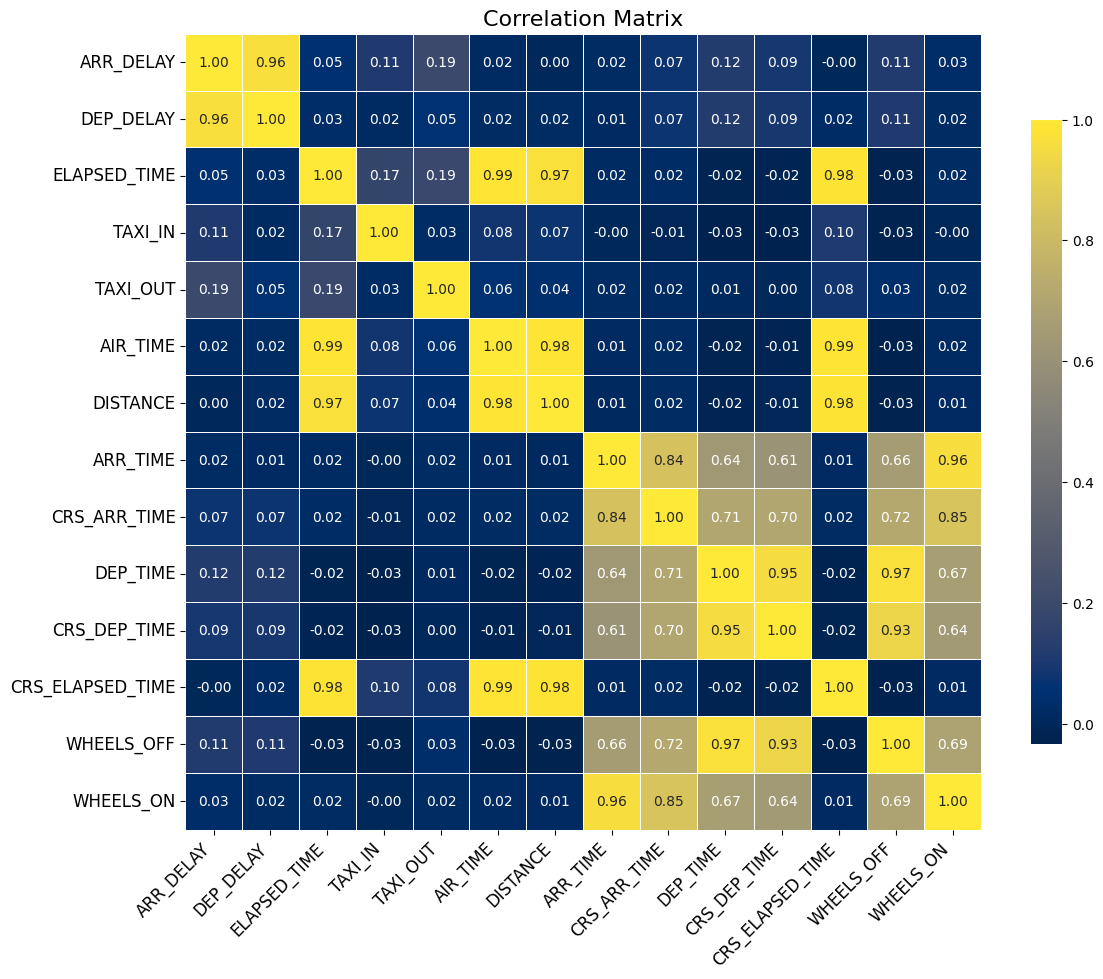

In [ ]:
#Find sensible correlations in the data between columns
columns = ["ARR_DELAY", "DEP_DELAY", "ELAPSED_TIME", "TAXI_IN", "TAXI_OUT", "AIR_TIME", "DISTANCE", "ARR_TIME", "CRS_ARR_TIME", "DEP_TIME", "CRS_DEP_TIME", "CRS_ELAPSED_TIME", "WHEELS_OFF", "WHEELS_ON"]
df_pandas = df.select(columns).toPandas()
correlation_matrix = df_pandas.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="cividis", fmt=".2f",
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.75})
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.savefig("./correlation_matrix.png", dpi=300)
plt.show()

AIR_TIME-ELAPSED TIME CORRELATION PLOT


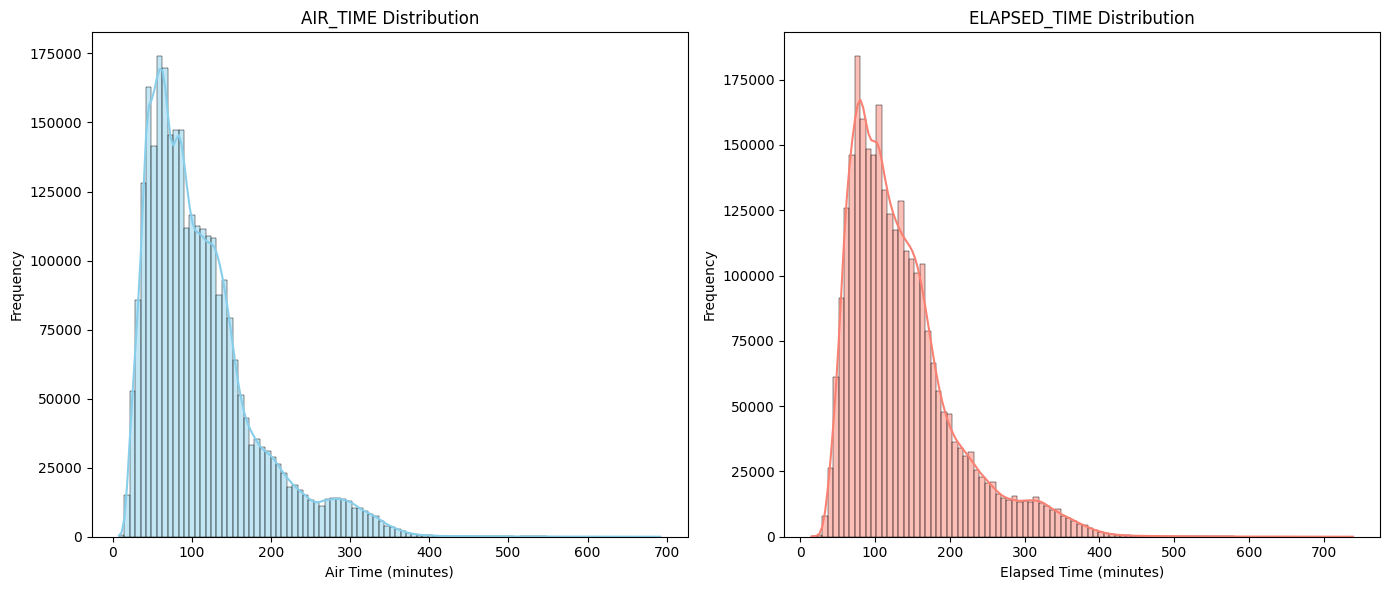

FLIGHT_TIME-DISTANCE CORRELATION PLOT


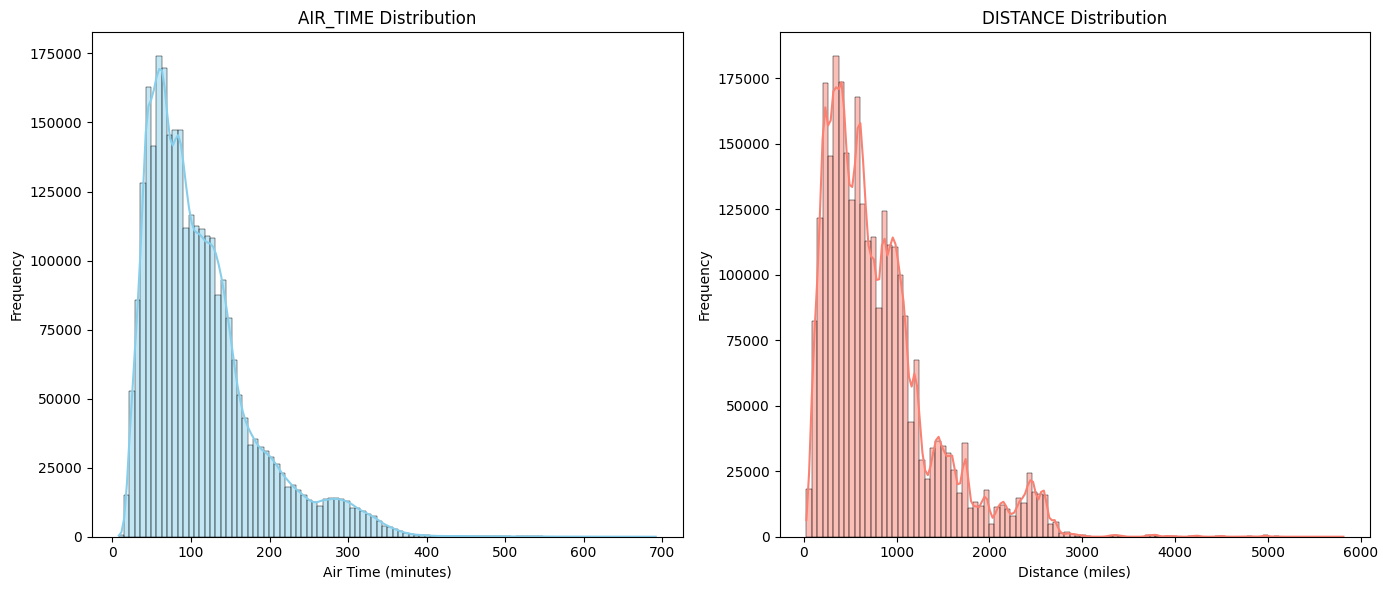

ARR_TIME-CRS_ARR_TIME CORRELATION PLOT


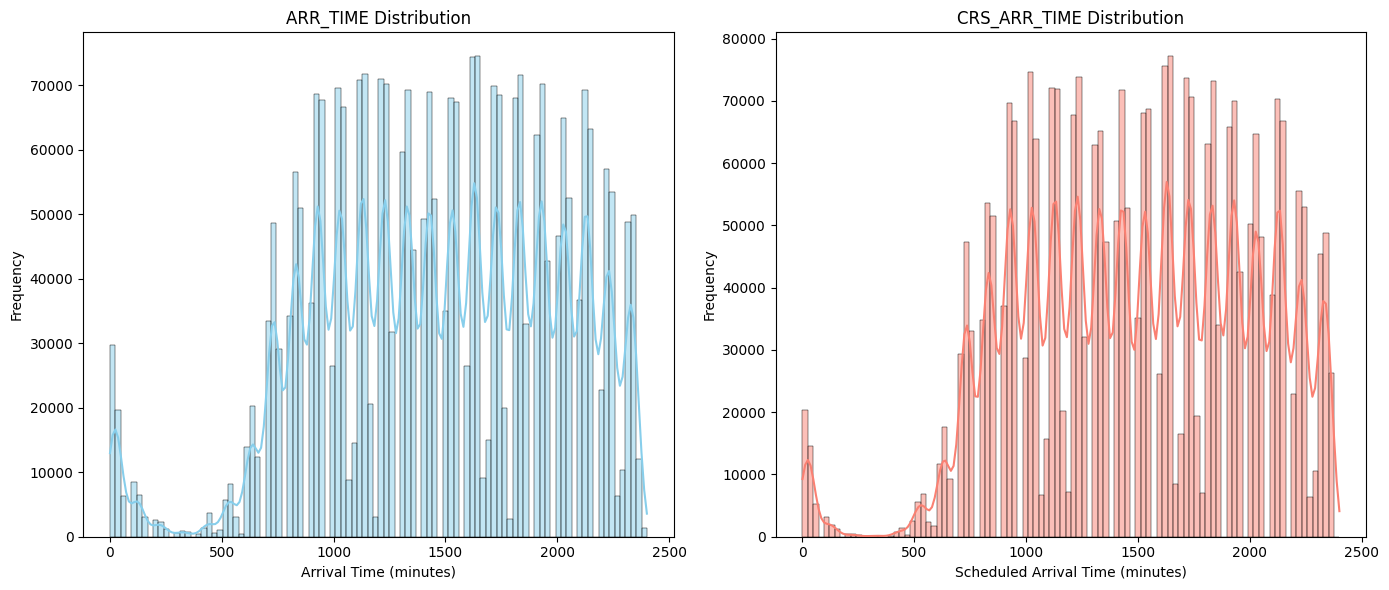

DEP_TIME-CRS_DEP_TIME CORRELATION PLOT


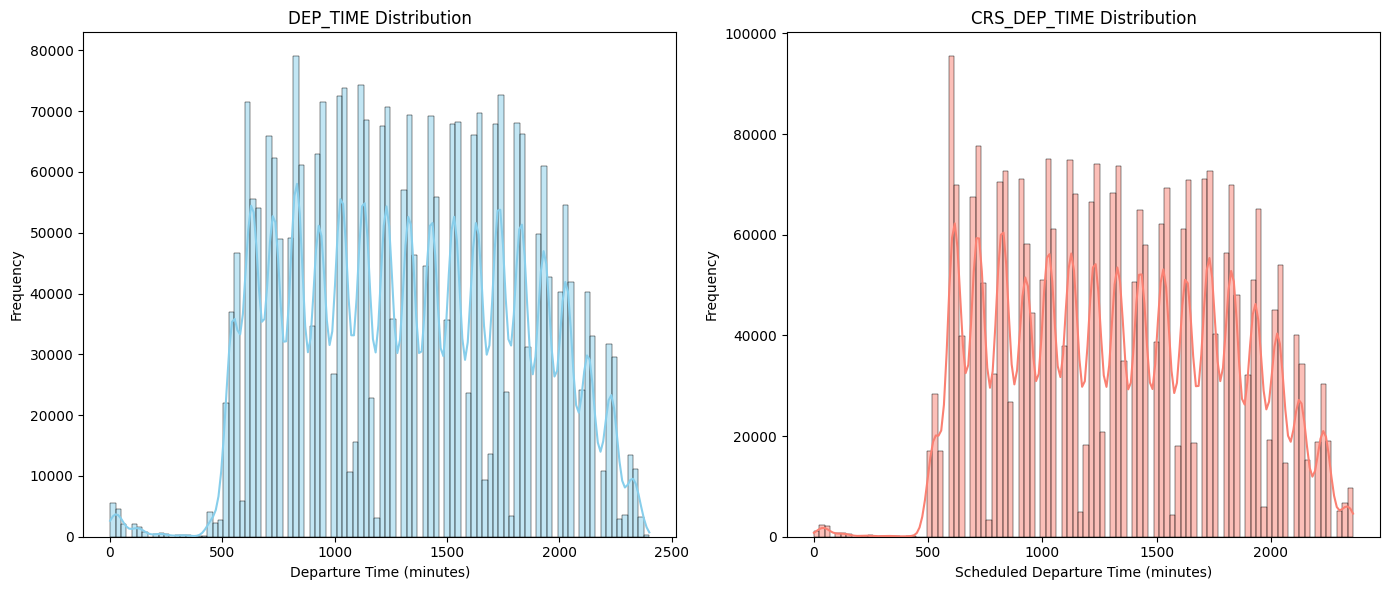

ELAPSED_TIME-CSR_ELAPSED_TIME CORRELATION PLOT


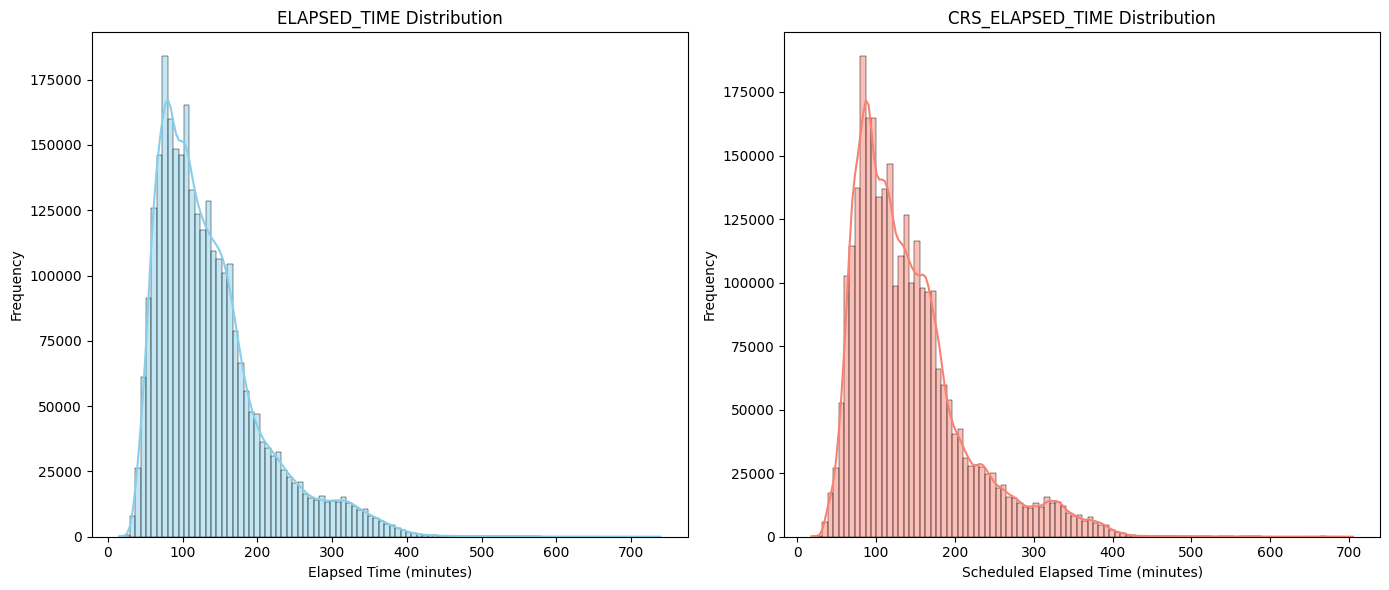

In [ ]:
#PLOT THE STRONG CORRELATIONS FOUND IN THE PREVIOUS CODE CELL
print("AIR_TIME-ELAPSED TIME CORRELATION PLOT")
air_time_df = df.select("AIR_TIME", "ELAPSED_TIME").toPandas()
air_time_df = air_time_df.dropna()
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(air_time_df['AIR_TIME'], kde=True, color='skyblue', bins=100)
plt.title('AIR_TIME Distribution')
plt.xlabel('Air Time (minutes)')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
sns.histplot(air_time_df['ELAPSED_TIME'], kde=True, color='salmon', bins=100)
plt.title('ELAPSED_TIME Distribution')
plt.xlabel('Elapsed Time (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("./AIR_TIME_ELAPSED_TIME_Correlation.png")
plt.show()

print("FLIGHT_TIME-DISTANCE CORRELATION PLOT")
flight_time_df = df.select("AIR_TIME", "DISTANCE").toPandas()
flight_time_df = flight_time_df.dropna()
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
sns.histplot(flight_time_df["AIR_TIME"], kde=True, color='skyblue', bins=100)
plt.title('AIR_TIME Distribution')
plt.xlabel('Air Time (minutes)')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
sns.histplot(flight_time_df["DISTANCE"], kde=True, color='salmon', bins=100)
plt.title('DISTANCE Distribution')
plt.xlabel('Distance (miles)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("./AIR_TIME_DISTANCE_Correlation.png")
plt.show()

print("ARR_TIME-CRS_ARR_TIME CORRELATION PLOT")
arr_time_df = df.select("ARR_TIME", "CRS_ARR_TIME").toPandas()
arr_time_df = arr_time_df.dropna()
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
sns.histplot(arr_time_df["ARR_TIME"], kde=True, color='skyblue', bins=100)
plt.title('ARR_TIME Distribution')
plt.xlabel('Arrival Time (minutes)')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
sns.histplot(arr_time_df["CRS_ARR_TIME"], kde=True, color='salmon', bins=100)
plt.title('CRS_ARR_TIME Distribution')
plt.xlabel('Scheduled Arrival Time (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("./ARR_TIME_CRS_ARR_TIME_Correlation.png")
plt.show()

print("DEP_TIME-CRS_DEP_TIME CORRELATION PLOT")
dep_time_df = df.select("DEP_TIME", "CRS_DEP_TIME").toPandas()
dep_time_df = dep_time_df.dropna()
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
sns.histplot(dep_time_df["DEP_TIME"], kde=True, color='skyblue', bins=100)
plt.title('DEP_TIME Distribution')
plt.xlabel('Departure Time (minutes)')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
sns.histplot(dep_time_df["CRS_DEP_TIME"], kde=True, color='salmon', bins=100)
plt.title('CRS_DEP_TIME Distribution')
plt.xlabel('Scheduled Departure Time (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("./DEP_TIME_CRS_DEP_TIME_Correlation.png")
plt.show()

print("ELAPSED_TIME-CSR_ELAPSED_TIME CORRELATION PLOT")
elapsed_time_df = df.select("ELAPSED_TIME", "CRS_ELAPSED_TIME").toPandas()
elapsed_time_df = elapsed_time_df.dropna()
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
sns.histplot(elapsed_time_df["ELAPSED_TIME"], kde=True, color='skyblue', bins=100)
plt.title('ELAPSED_TIME Distribution')
plt.xlabel('Elapsed Time (minutes)')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
sns.histplot(elapsed_time_df["CRS_ELAPSED_TIME"], kde=True, color='salmon', bins=100)
plt.title('CRS_ELAPSED_TIME Distribution')
plt.xlabel('Scheduled Elapsed Time (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("./ELAPSED_TIME_CRS_ELAPSED_TIME_Correlation.png")
plt.show()

**Identify missing values and find relationships between data columns**

First, we count all rows with missing value on field X, for each time field, and then we see exactly how these rows are characterized. It turns out that the majority are canceled flights, so we can ignore them, and the rest are diverted flights, which we can ignore since it is obvious they will be delayed by more than 15 minutes and since there is no way to calculate the real delay anyways.

In the mean time, we also try to look into the correlations found before, and find other relationships between the columns: it turns out that the elapsed time is the sum of taxi in, taxi out, and air time. This holds for all 3 milion columns but 3, so we conclude that those three rows are anomalies, and we can thus explain why air time and elapsed time were so correlated, since the air time is the main component that makes up the elapsed time.
We also find out that the delays are not a simple subtraction of arrival time and scheduled arrival time, since the arrival time might be one or two days later and there is no information on how many days have passed.
At the same time, all the "DELAY_DUE_X" fields come together, but most of the times they are NULL. This might be a problem, since an ML model cannot learn much from an NULL value.

In [ ]:
#Get the number of null values for the time fields
print(f"ARR_DELAY: {df.filter(col('ARR_DELAY').isNull() == True).count()}")
print(f"WHEELS_ON: {df.filter(col('WHEELS_ON').isNull() == True).count()}")
print(f"WHEELS_OFF: {df.filter(col('WHEELS_OFF').isNull() == True).count()}")
print(f"TAXI_OUT: {df.filter(col('TAXI_OUT').isNull() == True).count()}")
print(f"TAXI_IN: {df.filter(col('TAXI_IN').isNull() == True).count()}")
print(f"AIR_TIME: {df.filter(col('AIR_TIME').isNull() == True).count()}")
print(f"ELAPSED_TIME: {df.filter(col('ELAPSED_TIME').isNull() == True).count()}")
print(f"DEP_TIME: {df.filter(col('DEP_TIME').isNull() == True).count()}")
print(f"ARR_TIME: {df.filter(col('ARR_TIME').isNull() == True).count()}")
print(f"CRS_ARR_TIME: {df.filter(col('CRS_ARR_TIME').isNull() == True).count()}")
print(f"CRS_DEP_TIME: {df.filter(col('CRS_DEP_TIME').isNull() == True).count()}")
print(f"CRS_ELAPSED_TIME: {df.filter(col('CRS_DEP_TIME').isNull() == True).count()}")

Is it always the case that the arrival time is the subtraction between arrival time and scheduled arrival time?
+----------+--------------------+--------------------+------------+--------+---------+------+--------------+----+--------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|   FL_DATE|             AIRLINE|         AIRLINE_DOT|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|   ORIGIN_CITY|DEST|           DEST_CITY|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+----------+--------------------+--------------------+----

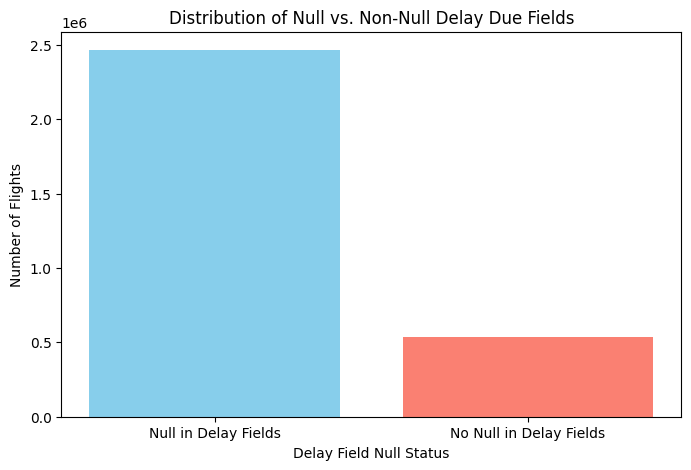

Test that, when there is a delay (positive) either on departure or arrival, if there are information on the nature of the delay (DELAY_DUE_CARRIER, DELAY_DUE_WEATHER,...), that info is the sum of reported arrival and delay time
False


In [ ]:
#TEST SOME HYPOTHESES ON HOW THE DATASET WORKS AND RELATIONSHIPS BETWEEN DATA POINTS

#Is it always the case that the arrival time is the subtraction between arrival time and scheduled arrival time? Result: no
print("Is it always the case that the arrival time is the subtraction between arrival time and scheduled arrival time?")
df.orderBy(F.desc("ARR_DELAY")).show(n=5)
print("This simple data reveals that no, this is not the case: some flights may be delayed by days,so it is not sufficient to look at arrival time and departure time, for they do not provide information on which days those hour times correspond to")
print("\n")
########################
#Test that elapsed time = air time + taxi in time + taxi out time: true, however three rows evade this rule
print("Test that elapsed time = air time + taxi in time + taxi out time ")
test = df.withColumn(
    "Hypothesis_Test",
    when((col("AIR_TIME") + col("TAXI_IN") + col("TAXI_OUT")) == col("ELAPSED_TIME"), True).otherwise(False)
)
print(test.filter((col("Hypothesis_Test") == False) & (col("ELAPSED_TIME").isNull() == False)).count())
test.filter((col("Hypothesis_Test") == False) & (col("ELAPSED_TIME").isNull() == False)).show()
print("The hypohtesis is not true for these three points, we must conclude that they are anomalies and will be eliminated\n")
############################
#Test that elapsed time = arrival time - departure time Results: no
print("Test that elapsed time = arrival time - departure time")
test = df.withColumn("ARR_TIME_MIN", to_minutes_udf(col("ARR_TIME"))) .withColumn("DEP_TIME_MIN", to_minutes_udf(col("DEP_TIME")))
test = test.withColumn(
    "Hypothesis_Test",
    when(col("ARR_TIME_MIN") - col("DEP_TIME_MIN") == col("ELAPSED_TIME"), True).otherwise(False)
)
print(test.filter((col("Hypothesis_Test") == False) & (col("ELAPSED_TIME").isNotNull())).count() == 0)

############################
#Test that, for each row, all DELAY_DUE fields (DELAY_DUE_CARRIER, ...) either are all present or none of them is present (all NULL) result: true
print("Test that, for each row, all DELAY_DUE fields (DELAY_DUE_CARRIER, ...) either are all present or none of them is present (all NULL)")
test1 = df.filter(
    (col("DELAY_DUE_CARRIER").isNull()) | (col("DELAY_DUE_NAS").isNull()) |
    (col("DELAY_DUE_WEATHER").isNull()) | (col("DELAY_DUE_SECURITY").isNull()) |
    (col("DELAY_DUE_LATE_AIRCRAFT").isNull())
)
test1 = test1.count()

test2 = df.filter(
    (col("DELAY_DUE_CARRIER").isNull()) & (col("DELAY_DUE_NAS").isNull()) &
    (col("DELAY_DUE_WEATHER").isNull()) & (col("DELAY_DUE_SECURITY").isNull()) &
    (col("DELAY_DUE_LATE_AIRCRAFT").isNull())
)
test2 = test2.count()
print(test1, test2, test1 == test2) #the returned numbers are the same, this means that indeed these values come in together
###########################
#Plot number of null vs non null DELAY_DUE FIELDS
null_count = df.filter(
    (col("DELAY_DUE_CARRIER").isNull()) |
    (col("DELAY_DUE_NAS").isNull()) |
    (col("DELAY_DUE_WEATHER").isNull()) |
    (col("DELAY_DUE_SECURITY").isNull()) |
    (col("DELAY_DUE_LATE_AIRCRAFT").isNull())
).count()

# Count rows without null values in all delay-related fields
non_null_count = df.filter(
    (col("DELAY_DUE_CARRIER").isNotNull()) &
    (col("DELAY_DUE_NAS").isNotNull()) &
    (col("DELAY_DUE_WEATHER").isNotNull()) &
    (col("DELAY_DUE_SECURITY").isNotNull()) &
    (col("DELAY_DUE_LATE_AIRCRAFT").isNotNull())
).count()
print("Null Count:", null_count)
print("Non-Null Count:", non_null_count)

# Prepare data for plotting
labels = ['Null in Delay Fields', 'No Null in Delay Fields']
counts = [null_count, non_null_count]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['skyblue', 'salmon'])
plt.title('Distribution of Null vs. Non-Null Delay Due Fields')
plt.xlabel('Delay Field Null Status')
plt.ylabel('Number of Flights')
plt.savefig('./Distribution_of_Null_vs._Non-Null_Delay_Due_Fields.png')
plt.show()
###########################
#Test that, when there is a delay (positive) either on departure or arrival, if there are information on the nature of the delay (DELAY_DUE_CARRIER,
# DELAY_DUE_WEATHER,...), that info is the sum of reported arrival and delay time") results: false
print("Test that, when there is a delay (positive) either on departure or arrival, if there are information on the nature of the delay (DELAY_DUE_CARRIER, DELAY_DUE_WEATHER,...), that info is the sum of reported arrival and delay time")
test = df.filter(
    (col("DELAY_DUE_CARRIER").isNull() == False) & (col("DELAY_DUE_NAS").isNull() == False) &
    (col("DELAY_DUE_WEATHER").isNull() == False) & (col("DELAY_DUE_SECURITY").isNull() == False) &
    (col("DELAY_DUE_LATE_AIRCRAFT").isNull() == False)
)
test = test.withColumn("Hypothesis_Test",
                     (col("DELAY_DUE_CARRIER") + col("DELAY_DUE_NAS") + col("DELAY_DUE_WEATHER") + col("DELAY_DUE_SECURITY") + col("DELAY_DUE_LATE_AIRCRAFT"))
                     == (when(col("ARR_DELAY") > 0.0, col("ARR_DELAY")).otherwise(0.0) +
                      when(col("DEP_DELAY") > 0.0, col("DEP_DELAY")).otherwise(0.0))
                    )
print(test.filter((col("Hypothesis_Test") == False)).count() == 0) #The hypothesis is False since it returns more than 0, also putting <= instead of == returns true, so this means that in no rows the delay_due fields form a total delay higher than the departure and arrival fields

**Studying the canceled and diverted flights**

Looking at all those rows that lack time values, we discover they are only diverted and canceled flights. Looking at the canceled flights, they lack any information, and they don't make much sense with respect to predicting a delay, since those flights do not happen. So we will remove them and study the remaining diverted flights.
We see then if it's possible to salvage at least the diverted flights, and whether they would constitute outliers or not.

In [ ]:
#Here we prove the fact that, all the flights that are missing the time values (except the DELAY_DUE_X fields),
# are indeed only the canceled and diverted flights
missing_dep_arr_data = df.filter(
    (col("DEP_TIME").isNull()) | (col("DEP_DELAY").isNull()) |
    (col("CRS_DEP_TIME").isNull()) | (col("CRS_ARR_TIME").isNull()) |
    (col("ARR_TIME").isNull()) | (col("ARR_DELAY").isNull()) |
    (col("CRS_ELAPSED_TIME").isNull()) |
    (col("ELAPSED_TIME").isNull())
)
print(missing_dep_arr_data.count())

#Remove all the canceled flights from the dataset
df = df.filter(col("CANCELLED") != 1.0)
df = df.drop("CANCELLED")
print("Let's again count the number of missing field data points for the dataset without the cancelled flights points")
print(f"ARR_DELAY: {df.filter(col('ARR_DELAY').isNull() == True).count()}")
print(f"WHEELS_ON: {df.filter(col('WHEELS_ON').isNull() == True).count()}")
print(f"WHEELS_OFF: {df.filter(col('WHEELS_OFF').isNull() == True).count()}")
print(f"TAXI_OUT: {df.filter(col('TAXI_OUT').isNull() == True).count()}")
print(f"TAXI_IN: {df.filter(col('TAXI_IN').isNull() == True).count()}")
print(f"AIR_TIME: {df.filter(col('AIR_TIME').isNull() == True).count()}")
print(f"ELAPSED_TIME: {df.filter(col('ELAPSED_TIME').isNull() == True).count()}")
print(f"DEP_TIME: {df.filter(col('DEP_TIME').isNull() == True).count()}")
print(f"ARR_TIME: {df.filter(col('ARR_TIME').isNull() == True).count()}")

#DEP_TIME, TAXI_OUT, and WHEELS_OFF counts are now 0, so these fields are present in every non canceled flight
print("\n")
print("Remove also diverted fligths and count again")
df = df.filter(col("DIVERTED") != 1.0)
df = df.drop("DIVERTED")
print(f"ARR_DELAY: {df.filter(col('ARR_DELAY').isNull() == True).count()}")
print(f"WHEELS_ON: {df.filter(col('WHEELS_ON').isNull() == True).count()}")
print(f"WHEELS_OFF: {df.filter(col('WHEELS_OFF').isNull() == True).count()}")
print(f"TAXI_OUT: {df.filter(col('TAXI_OUT').isNull() == True).count()}")
print(f"TAXI_IN: {df.filter(col('TAXI_IN').isNull() == True).count()}")
print(f"AIR_TIME: {df.filter(col('AIR_TIME').isNull() == True).count()}")
print(f"ELAPSED_TIME: {df.filter(col('ELAPSED_TIME').isNull() == True).count()}")
print(f"DEP_TIME: {df.filter(col('DEP_TIME').isNull() == True).count()}")
print(f"ARR_TIME: {df.filter(col('ARR_TIME').isNull() == True).count()}")
print("\nOnly two anomalies remain, we will eliminate them as they offer no way to infer the delay:")
df.filter(col("ARR_DELAY").isNull()).show()
#This code proves that the number of flights that don't have certain time measures is the same to the number of diverted flights that
# do not have those same time measures (minus two anomalous rows)

86198
Let's again count the number of missing field data points for the dataset without the cancelled points
ARR_DELAY: 7058
WHEELS_ON: 804
WHEELS_OFF: 0
TAXI_OUT: 0
TAXI_IN: 804
AIR_TIME: 7058
ELAPSED_TIME: 7058
DEP_TIME: 0
ARR_TIME: 802


Remove also divertede fligths and count again
ARR_DELAY: 2
WHEELS_ON: 2
WHEELS_OFF: 0
TAXI_OUT: 0
TAXI_IN: 2
AIR_TIME: 2
ELAPSED_TIME: 2
DEP_TIME: 0
ARR_TIME: 2

Only two anomalies remain, we will eliminate them:

+----------+--------------------+--------------------+------------+--------+---------+------+------------+----+-------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+-----------------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|   FL_DATE|             AIRLINE|         AIRLINE_DOT|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN| ORIGIN_CITY|DEST|    DEST_CITY|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|T

Most of the flights that don't contain the direct information are cancelled or diverted, and their count does add up to 86198. Here we prove that these flights constitute basically all the rows that are missing vital information with regards to the delay calculation time.

In [ ]:
#Calculate again number of canceled flights and number of diverted flights separately
canceled_flights_data = df.filter(
    (col("CANCELLED") == 1))
diverted_flights_data = df.filter(
    (col("DIVERTED") == 1))
print(canceled_flights_data.count())
print(diverted_flights_data.count())

#See that they indeed are the same flights
canceled_flights_data = missing_dep_arr_data.filter(
    (col("CANCELLED") == 1))
diverted_flights_data = missing_dep_arr_data.filter(
    (col("DIVERTED") == 1))
print(f"Number of canceled flights is: {canceled_flights_data.count()}")
print(f"Number of diverted flights :{diverted_flights_data.count()}")

79140
7056
Number of canceled flights is: 79140
Number of diverted flights :7056
ARR_DELAY: 7058
WHEELS_ON: 804
WHEELS_OFF: 0
TAXI_OUT: 0
TAXI_IN: 804
AIR_TIME: 7058
ELAPSED_TIME: 7058
DEP_TIME: 0
ARR_TIME: 802


ARR_DELAY_DIVERTED_FLIGHTS: 7056
WHEELS_ON_DIVERTED_FLIGHTS: 802
TAXI_IN_DIVERTED_FLIGHTS: 802
AIR_TIME_DIVERTED_FLIGHTS: 7056
ELAPSED_TIME_DIVERTED_FLIGHTS: 7056
ARR_TIME_DIVERTED_FLIGHTS: 800


+----------+--------------------+--------------------+------------+--------+---------+------+--------------------+----+--------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|   FL_DATE|             AIRLINE|         AIRLINE_DOT|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|         ORIGIN_CITY|DEST|           DEST_CITY|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+----------+--------------------+--------------------+------------+--------+---------+------+--------------------+----+--------------------+------------+-----

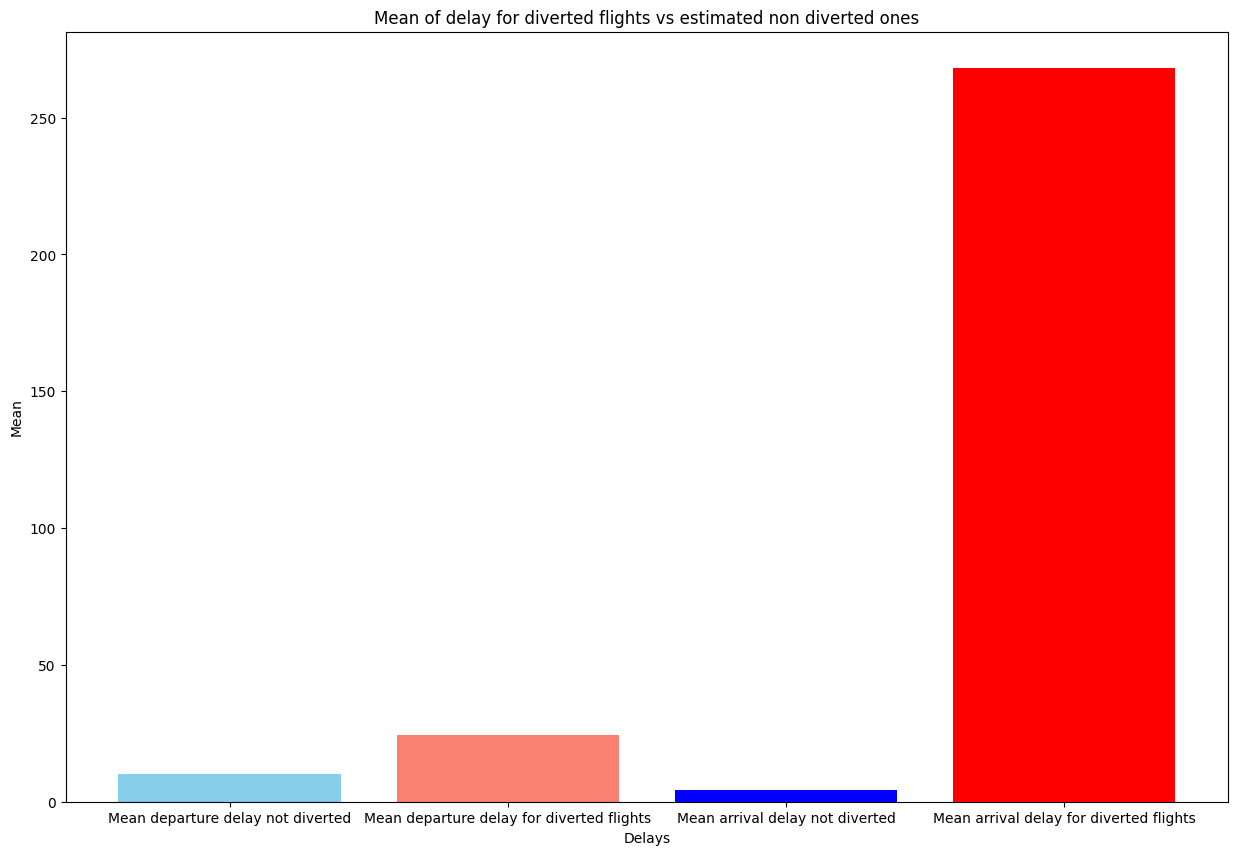

In [ ]:
#Look for patterns in the diverted flights delays vs non diverted ones to assess if they would constitute outlieers
#First, infer all the values of arrival delay when possible
#We need a user defined function "to_minutes" within spark to convert ARRTIME and CRSARRTIME from hhmm format to minutes
diverted_flights_data = df.filter(
    (col("DIVERTED") == 1))
diverted_flights_data = diverted_flights_data.filter(col("ARR_TIME").isNotNull()) #some rows don't even have arr_time -> it's impossible to salvage them
diverted_flights_data = diverted_flights_data.withColumn(
    "ARR_TIME_MIN", to_minutes_udf(col("ARR_TIME"))
).withColumn("CRS_ARR_TIME_MIN", to_minutes_udf(col("CRS_ARR_TIME"))) #conversion from hhmm to minutes for the calculation
#The calculation of the delay_arr time follows this formula: if the departure time is lower than the arrival time, the flight is assumed to have taken place
# in the same day, and so we do a normal subtraction of arrival time - scheduled time. Otherwise, we have an indication that the flight arrived the next day, so
# we add up the arr_time + the hours from departure time to midnight.
#Such a formula is clearly optimistic: we have no way to tell in principle if the arr_time is set the next or two days after the departure time, so we are making a conservative estimate
diverted_flights_data = diverted_flights_data.withColumn(
    "ARR_DELAY", when((col("ARR_DELAY").isNull()) & (col("DEP_TIME") < col("ARR_TIME")), col("ARR_TIME_MIN") - col("CRS_ARR_TIME_MIN")).otherwise(col("ARR_DELAY")))
diverted_flights_data = diverted_flights_data.withColumn(
    "ARR_DELAY", when((col("ARR_DELAY").isNull()) & (col("DEP_TIME") >= col("ARR_TIME")), col("ARR_TIME_MIN") + 24*60 - col("CRS_ARR_TIME_MIN")).otherwise(col("ARR_DELAY")))
diverted_flights_data = diverted_flights_data.drop("ARR_TIME_MIN").drop("CRS_ARR_TIME_MIN")
diverted_flights_data.show()
#Get all non diverted flights
not_diverted_flights_data = df.filter(col("DIVERTED") == 0.0)
#Calculate means of not diverted flights delays wrt to diverted ones and plot them
mean_dep_delay_df = not_diverted_flights_data.agg(F.mean("DEP_DELAY")).collect()[0][0]
mean_dep_delay_diverted_flights_df = diverted_flights_data.agg(F.mean("DEP_DELAY")).collect()[0][0]
mean_arr_delay_df = not_diverted_flights_data.agg(F.mean("ARR_DELAY")).collect()[0][0]
mean_arr_delay_diverted_flights_df = diverted_flights_data.agg(F.mean("ARR_DELAY")).collect()[0][0]
labels = ['Mean departure delay not diverted', 'Mean departure delay for diverted flights', 'Mean arrival delay not diverted', 'Mean arrival delay for diverted flights']
counts = [mean_dep_delay_df, mean_dep_delay_diverted_flights_df, mean_arr_delay_df, mean_arr_delay_diverted_flights_df]

plt.figure(figsize=(15, 10))
plt.bar(labels, counts, color=['skyblue', 'salmon', 'blue', 'red'])
plt.title('Mean of delay for diverted flights vs estimated non diverted ones')
plt.xlabel('Delays')
plt.ylabel('Mean')
plt.savefig('./Mean_of_delay_for_diverted_flights_vs_non_diverted.png')
plt.show()

**Counting outliers**

Finally, we count all remaining outliers and asses their number with respect to the total remaining number of data points. For our purposes, we define an outlier an arrival delay value that is larger than 3 times the standard deviation from the mean or smaller than -3 times the standard deviation from the mean.

4.260858150279257 51.174824360595935


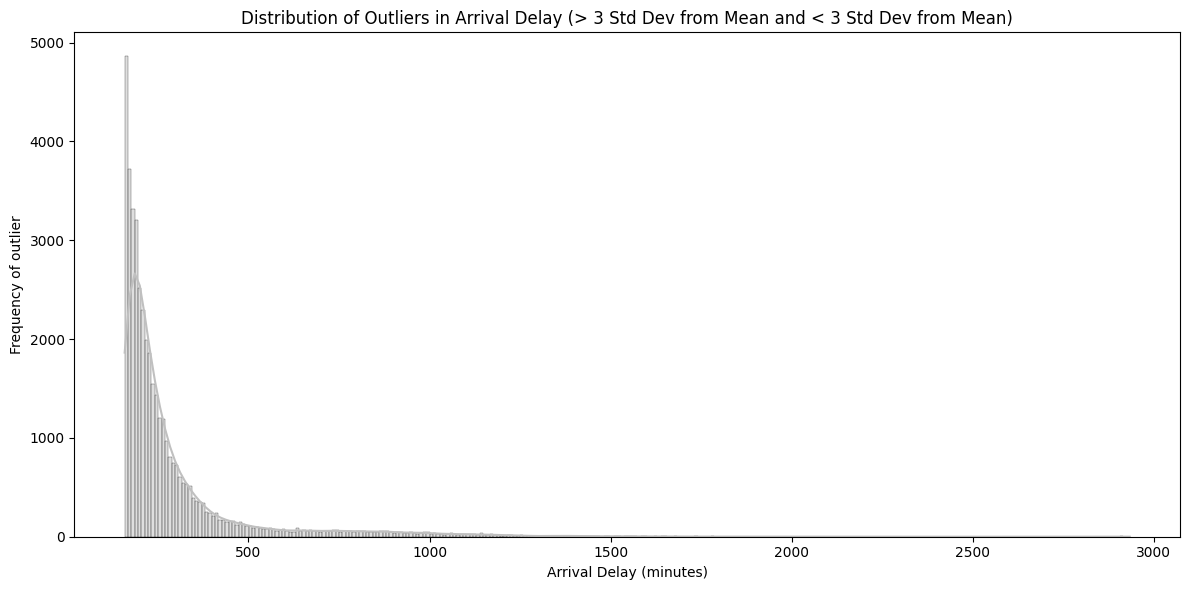

The percentage out outliers is: 0.014541139034155375
The number of outliers is: 42370
The number of non outliers is: 2871432


In [ ]:
#Get stddev and maen
stats = df.selectExpr("mean(ARR_DELAY) as mean", "stddev(ARR_DELAY) as stddev").first()
mean, stddev = stats['mean'], stats['stddev']
print(mean, stddev)

#need to convert to a pandas dataset to use sns plotting
outliers_df = df.filter(df["ARR_DELAY"].isNotNull() & ((df["ARR_DELAY"] > mean + 3 * stddev) | (df["ARR_DELAY"] < mean - 3 * stddev)))
N_outliers = outliers_df.count()
outliers_pd = outliers_df.select("ARR_DELAY").toPandas()

plt.figure(figsize=(12, 6))
sns.histplot(outliers_pd["ARR_DELAY"], kde=True, color='silver', bins=300) #plot in bins
plt.title("Distribution of Outliers in Arrival Delay (> 3 Std Dev from Mean and < 3 Std Dev from Mean)")
plt.xlabel("Arrival Delay (minutes)")
plt.ylabel("Frequency of outlier")
plt.tight_layout()
plt.savefig("./Distribution_of_Outliers_in_Arrival_Delay.png")
plt.show()

#Get percentage of outliers out of all the rows
print(f"The percentage out outliers is: {N_outliers/df.filter(df['ARR_DELAY'].isNotNull()).count()}")
#Compare number of outliers with respect to non outliers
print(f"The number of outliers is: {N_outliers}")
print(f"The number of non outliers is: {df.filter(df['ARR_DELAY'].isNotNull()).count() - N_outliers}")

**Other data**

We study now the distribution of all the other data dimensions that do not tell anything (directly) about the time.

In [ ]:
#DETECT FURTHER NULLS -> no null values detected for non time fields
print(f"FL_DATE: {df.filter(col('FL_DATE').isNull() == True).count()}")
print(f"AIRLINE: {df.filter(col('AIRLINE').isNull() == True).count()}")
print(f"AIRLINE_DOT: {df.filter(col('AIRLINE_DOT').isNull() == True).count()}")
print(f"AIRLINE_CODE: {df.filter(col('AIRLINE_CODE').isNull() == True).count()}")
print(f"DOT_CODE: {df.filter(col('DOT_CODE').isNull() == True).count()}")
print(f"FL_NUMBER: {df.filter(col('FL_NUMBER').isNull() == True).count()}")
print(f"ORIGIN: {df.filter(col('ORIGIN').isNull() == True).count()}")
print(f"ORIGIN_CITY: {df.filter(col('ORIGIN_CITY').isNull() == True).count()}")
print(f"DEST: {df.filter(col('DEST').isNull() == True).count()}")
print(f"DEST_CITY: {df.filter(col('DEST_CITY').isNull() == True).count()}")
print(f"DISTANCE: {df.filter(col('DISTANCE').isNull() == True).count()}")

FL_DATE: 0
AIRLINE: 0
AIRLINE_DOT: 0
AIRLINE_CODE: 0
DOT_CODE: 0
FL_NUMBER: 0
ORIGIN: 0
ORIGIN_CITY: 0
DEST: 0
DEST_CITY: 0
DISTANCE: 0


In [ ]:
#Check that these values are unique --> none of them are, at least by themselves
print(f"Total number of rows: {N}")
print(f"AIRLINE rows: {df.select('AIRLINE').distinct().count()}")
print(f"AIRLINE_DOT rows: {df.select('AIRLINE_DOT').distinct().count()}")
print(f"AIRLINE_CODE rows: {df.select('AIRLINE_CODE').distinct().count()}")
print(f"DOT_CODE rows: {df.select('DOT_CODE').distinct().count()}")
print(f"FL_NUMBER rows: {df.select('FL_NUMBER').distinct().count()}")
print(f"ORIGIN rows: {df.select('ORIGIN').distinct().count()}")
print(f"ORIGIN_CITY rows: {df.select('ORIGIN_CITY').distinct().count()}")
print(f"DEST rows: {df.select('DEST').distinct().count()}")
print(f"DEST_CITY rows: {df.select('DEST_CITY').distinct().count()}")

Total number of rows: 3000000
AIRLINE rows: 18
AIRLINE_DOT rows: 18
AIRLINE_CODE rows: 18
DOT_CODE rows: 18
FL_NUMBER rows: 7111
ORIGIN rows: 380
ORIGIN_CITY rows: 373
DEST rows: 380
DEST_CITY rows: 373


We think of interest a study on the distribution of delays for AIRLINE CODE, DOT_CODE, DISTANCE, ORIGIN, ORIGIN_CITY, DEST, DEST_CITY.

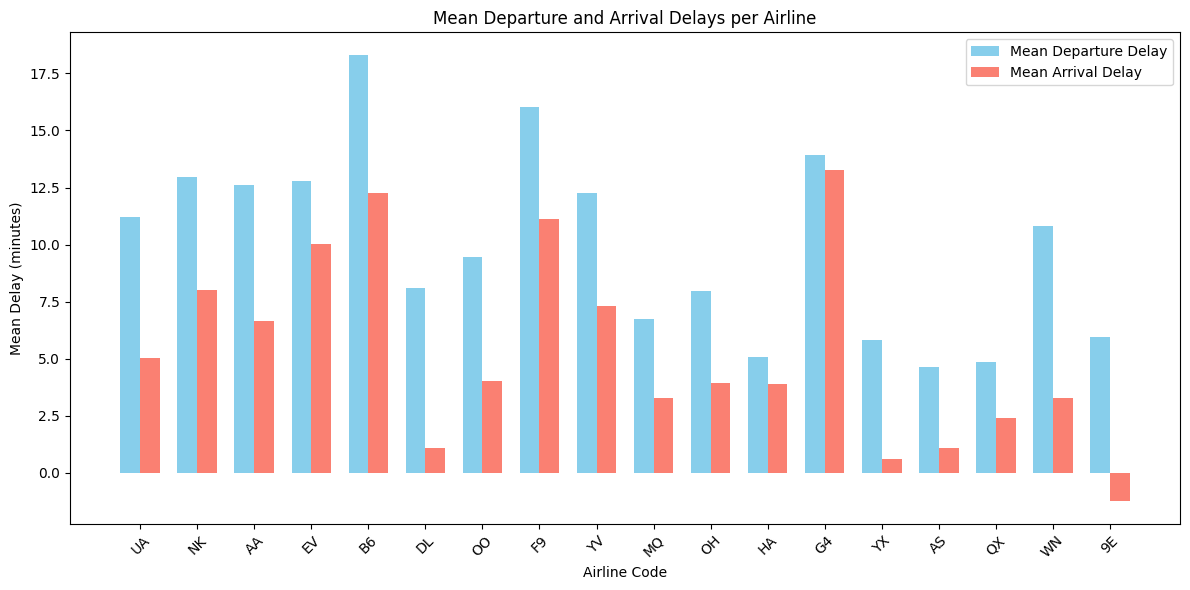

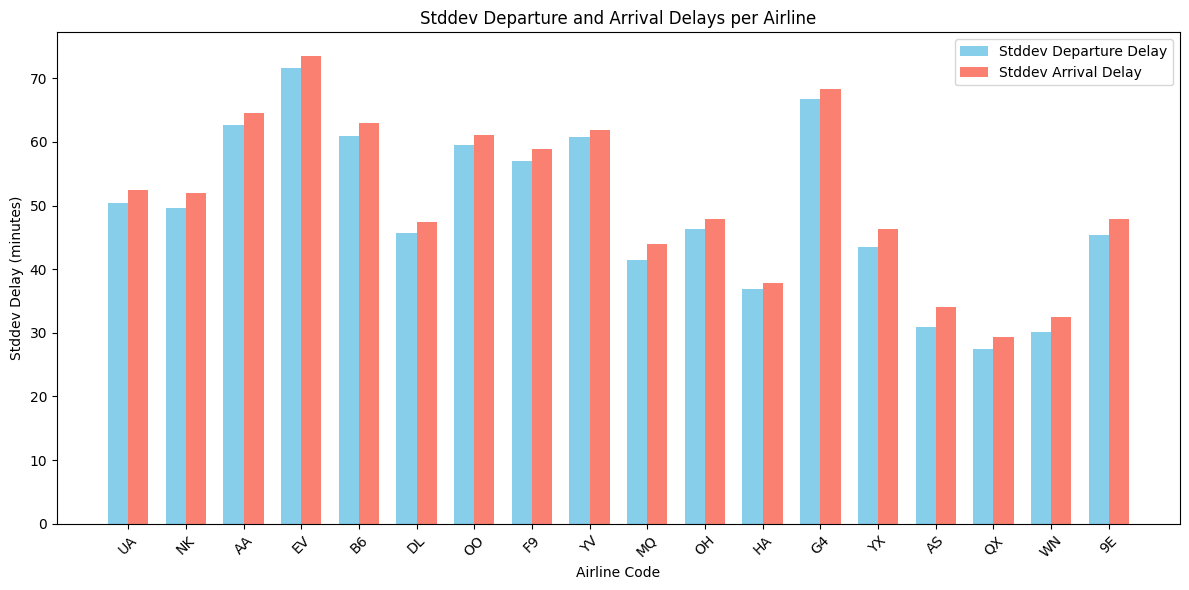

In [ ]:
#AIRLINE CODE AND INDICATE THE SAME THING
mean_delays_per_airline = (
    df.groupBy("AIRLINE_CODE")
    .agg(
        F.mean("DEP_DELAY").alias("mean_dep_delay"),
        F.mean("ARR_DELAY").alias("mean_arr_delay")
    )
)
results = mean_delays_per_airline.collect()
airline_codes = [row['AIRLINE_CODE'] for row in results]
mean_dep_delays = [row['mean_dep_delay'] for row in results]
mean_arr_delays = [row['mean_arr_delay'] for row in results]

plt.figure(figsize=(12, 6))
bar_width = 0.35
index = range(len(airline_codes))
plt.bar(index, mean_dep_delays, bar_width, label='Mean Departure Delay', color='skyblue')
plt.bar([i + bar_width for i in index], mean_arr_delays, bar_width, label='Mean Arrival Delay', color='salmon')
plt.xlabel('Airline Code')
plt.ylabel('Mean Delay (minutes)')
plt.title('Mean Departure and Arrival Delays per Airline')
plt.xticks([i + bar_width / 2 for i in index], airline_codes, rotation=45)
plt.legend()

plt.tight_layout()
plt.savefig("./Mean_Departure_and_Arrival_Delays_per_Airline.png")
plt.show()
##########################################################
stddev_delays_per_airline = (
    df.groupBy("AIRLINE_CODE")
    .agg(
        F.stddev("DEP_DELAY").alias("stddev_dep_delay"),
        F.stddev("ARR_DELAY").alias("stddev_arr_delay")
    )
)
results = stddev_delays_per_airline.collect()
airline_codes = [row['AIRLINE_CODE'] for row in results]
stddev_dep_delays = [row['stddev_dep_delay'] for row in results]
stddev_arr_delays = [row['stddev_arr_delay'] for row in results]
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = range(len(airline_codes))
plt.bar(index, stddev_dep_delays, bar_width, label='Stddev Departure Delay', color='skyblue')
plt.bar([i + bar_width for i in index], stddev_arr_delays, bar_width, label='Stddev Arrival Delay', color='salmon')
plt.xlabel('Airline Code')
plt.ylabel('Stddev Delay (minutes)')
plt.title('Stddev Departure and Arrival Delays per Airline')
plt.xticks([i + bar_width / 2 for i in index], airline_codes, rotation=45)
plt.legend()

plt.tight_layout()
plt.savefig("./Stddev_Departure_and_Arrival_Delays_per_Airline.png")
plt.show()
##########################################################


**PART 2: PREPROCESS THE DATASET**

In the following cell, all the chosen policies with respect to the dataset will be applied. The reasoning for these policies is documented in sections 1.1 and 1.2 of the Report. To summarize: fields like FL_DATE, WHEELS_OFF, WHEELS_ON, TAXI_IN and TAXI_OUT are useless to infer anything about the delay, and tehy will be eliminated. AIRLINE and AIR_DOT will be eliminated because they are better encoded in AIRLINE_CODE and DOT_CODE. Finally, CANCELLED, CANCELLATION_CODE and DIVERTED lose their use once we remove the cancelled and diverted flights. ORIGIN_CITY and DEST_CITY are removed because they represent the cities, but we are more interested in airport-to-airport flights.

In [ ]:
#Remove cancelled flights
df = df.filter(col("CANCELLED") == 0.0).drop("CANCELLED").drop("CANCELLATION_CODE")
#Remove diverted flights
df = df.filter(col("DIVERTED") == 0.0).drop("DIVERTED")
#Remove the two anomalous data points that don't have the arr delay even though they are not cancelled nor diverted
df = df.filter(col("ARR_DELAY").isNotNull())
#Remove the three anomalous data points that don't satisfy the equation: elapsed_time = air_time + taxi_in + taxi_out
df = df.filter(col("ELAPSED_TIME") == col("AIR_TIME") + col("TAXI_IN") + col("TAXI_OUT"))
#Remove fields that are not very informative, or have another better encoding in another field
df = df.drop("WHEELS_ON").drop("WHEELS_OFF").drop("FL_DATE").drop("TAXI_OUT").drop("TAXI_IN").drop("AIRLINE").drop("AIRLINE_DOT").drop("ORIGIN_CITY").drop("DEST_CITY")
#Remove the DELAY_DUE fields, since they are almost always NULL and give us insufficient information
df = df.drop("DELAY_DUE_CARRIER", "DELAY_DUE_NAS", "DELAY_DUE_WEATHER", "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT")

Convert categorical variables (e.g., airline codes, airport codes) into numerical format
using StringIndexer and OneHotEncoder. Assemble all feature columns into a single feature vec-
tor with VectorAssembler. Split the dataset into training and testing sets (e.g., 80% training, 20%
testing)-

In [ ]:
#Define indexers and OneHotEncoders
airline_indexer = StringIndexer(inputCol="AIRLINE_CODE", outputCol="AIRLINE_CODE_Indexed")
airline_encoder = OneHotEncoder(inputCol="AIRLINE_CODE_Indexed", outputCol="AIRLINE_CODE_OneHot")

airport_indexer = StringIndexer(inputCol="AIRPORT", outputCol="AIRPORT_Indexed")
origin_encoder = OneHotEncoder(inputCol="ORIGIN_Indexed", outputCol="ORIGIN_OneHot")
dest_encoder = OneHotEncoder(inputCol="DEST_Indexed", outputCol="DEST_OneHot")

#To encode origin and dest values with same index, we need to unify the values first, create indexing on the single column, join it with the Origin and DEST and apply indexing
airport_df = df.select(col("ORIGIN").alias("AIRPORT")).union(df.select(col("DEST").alias("AIRPORT"))).distinct()
airport_indexed_df = airport_indexer.fit(airport_df).transform(airport_df)
df = df.join(airport_indexed_df.withColumnRenamed("AIRPORT", "ORIGIN").withColumnRenamed("AIRPORT_Indexed", "ORIGIN_Indexed"), on="ORIGIN", how="left")
df = df.join(airport_indexed_df.withColumnRenamed("AIRPORT", "DEST").withColumnRenamed("AIRPORT_Indexed", "DEST_Indexed"), on="DEST", how="left")

In [ ]:
#Define Vector Assembler
assembler = VectorAssembler(
    inputCols=["AIRLINE_CODE_OneHot", "DOT_CODE", "ORIGIN_OneHot", "DEST_OneHot",
               "CRS_DEP_TIME", "DEP_TIME", "DEP_DELAY",
               "CRS_ARR_TIME", "CRS_ELAPSED_TIME", "ELAPSED_TIME",
               "AIR_TIME", "DISTANCE"],
    outputCol="features"
)
#Define Pipeline, it takes a series of stages and applies them sequentially
pipeline = Pipeline(stages=[airline_indexer, airline_encoder, origin_encoder, dest_encoder, assembler])
pip = pipeline.fit(df)
df = pip.transform(df)
df = df.withColumn("label", when(df["ARR_DELAY"] > 15.0, 1).otherwise(0)) #add label column for classification
#Keep only feature vector and labels
df = df.select("features", "label")
df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(784,[3,17,54,505...|    0|
|(784,[7,17,54,607...|    0|
|(784,[3,17,54,505...|    0|
|(784,[3,17,54,505...|    0|
|(784,[3,17,54,505...|    0|
|(784,[3,17,54,505...|    0|
|(784,[3,17,54,505...|    0|
|(784,[7,17,54,505...|    0|
|(784,[3,17,54,505...|    0|
|(784,[3,17,54,505...|    1|
|(784,[7,17,54,505...|    0|
|(784,[7,17,54,607...|    0|
|(784,[3,17,54,505...|    0|
|(784,[3,17,54,505...|    1|
|(784,[7,17,54,505...|    0|
|(784,[7,17,54,505...|    0|
|(784,[3,17,54,505...|    0|
|(784,[3,17,54,505...|    0|
|(784,[7,17,54,505...|    0|
|(784,[3,17,54,505...|    0|
+--------------------+-----+
only showing top 20 rows



In [ ]:
#Save dataset
df.write.mode("overwrite").parquet("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/df_transformed.parquet")

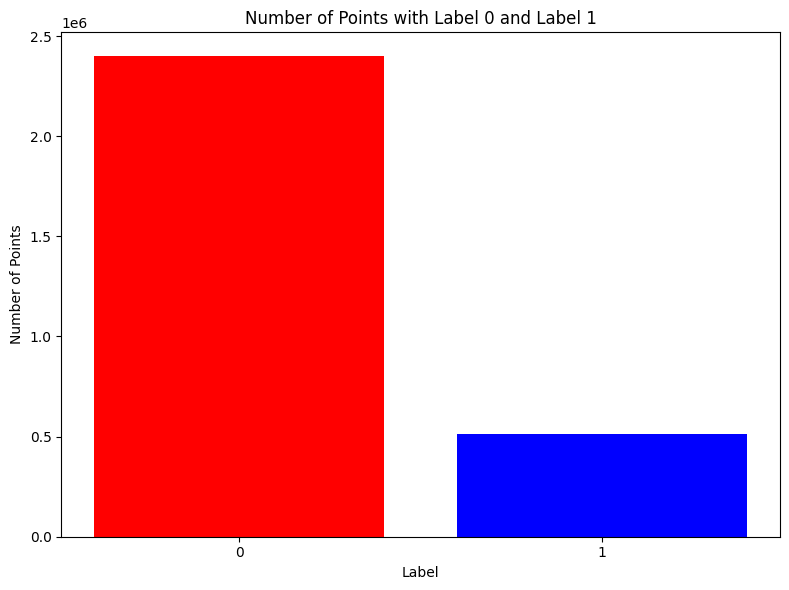

In [ ]:
#Count the distribution of positives with respect to negatives in the dataset
label_counts = df.groupBy("label").count().toPandas()
plt.figure(figsize=(8, 6))
plt.bar(label_counts['label'], label_counts['count'], color=['blue', 'red'])
plt.xlabel('Label')
plt.ylabel('Number of Points')
plt.title('Number of Points with Label 0 and Label 1')
plt.xticks([0, 1])
plt.tight_layout()
plt.savefig("./Label_Distribution.png")
plt.show()

**PART 3: ML MODELS TRAINING AND COMPARISON**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Create the datasets
df = spark_s.read.parquet("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/df_transformed.parquet")
normalized = False
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
train_df.show(n=5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                  |label|
+--------------------------------------------------------------------------------------------------------------------------+-----+
|(784,[0,17,20,423,776,777,778,779,780,781,782,783],[1.0,19393.0,1.0,1.0,545.0,537.0,-8.0,830.0,105.0,97.0,83.0,619.0])    |0    |
|(784,[0,17,20,423,776,777,778,779,780,781,782,783],[1.0,19393.0,1.0,1.0,545.0,544.0,-1.0,830.0,105.0,97.0,83.0,619.0])    |0    |
|(784,[0,17,20,423,776,777,778,779,780,781,782,783],[1.0,19393.0,1.0,1.0,640.0,636.0,-4.0,925.0,105.0,89.0,77.0,619.0])    |0    |
|(784,[0,17,20,423,776,777,778,779,780,781,782,783],[1.0,19393.0,1.0,1.0,715.0,713.0,-2.0,1000.0,105.0,95.0,81.0,619.0])   |0    |
|(784,[0,17,20,423,776,777,778,779,780,781,782,783],[1.0,19393.0,1.0,1.0,755.0,753.

**The models**

We will now start training and evaluating different ML models. In the following code we create the Logistic Regression model, use a five-fold cross validator to train it and find the best parameters combination and save it. The hyper-parameters are stored in the param grid. The binary classification evaluator is an evaluator that calculates the AUC, which is the area under the ROC curve, that evaluates the probability that, given a positive and a negative, the positive will be evaluated by the model as 1 and the negative will be evaluated as 0.
The MultiClassClassificationEvaluator class is used to calculate other metrics, such as the F1-score, the precision and the recall, which cannot be calculated by the binary classification evaluator. For each model, we will also both use normalize and non normalized to compare results.

In [ ]:
#Training with normalized features: execute to use normalization
normalized = True
#The standard scaler is used to normalize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(train_df)
train_df = scaler_model.transform(train_df)
train_df = train_df.drop("features").withColumnRenamed("scaled_features", "features")
test_df = scaler_model.transform(test_df)
test_df = test_df.drop("features").withColumnRenamed("scaled_features", "features")
train_df.show(truncate=False)

+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                                                                                                                 |
+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |(784,[0,17,20,423,776,777,778,779,780,781,782,783],[2.545583752765676,51.514807448690284,17.957026349945334,9.6339379696668

In [ ]:
def print_metrics(predictions, normalized, model, evaluator):
  #Model is model name, normalized a boolean to tell if the dataset was normalized or not and the predictions are the model's returned predictions
  auc = evaluator.evaluate(predictions)
  prob_label_df = predictions.select("probability", "label")
  prob_label_data = prob_label_df.collect()

  tpr_values = []
  fpr_values = []
  thresholds = [i/100 for i in range(100)] #thresholds for labeling

  #Calculate true positive rate and false positive rate for any threshold to plot the ROC curve
  for threshold in thresholds:
      tp = fp = tn = fn = 0
      for row in prob_label_data:
          prob = row['probability'][1]  #Probability of positive class
          actual = row['label']
          predicted = 1 if prob >= threshold else 0  #Apply threshold to predict label
          #Update confusion matrix counters
          if predicted == 1 and actual == 1:
              tp += 1
          elif predicted == 1 and actual == 0:
              fp += 1
          elif predicted == 0 and actual == 0:
              tn += 1
          elif predicted == 0 and actual == 1:
              fn += 1
      #Calculate TPR and FPR
      tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
      fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
      tpr_values.append(tpr)
      fpr_values.append(fpr)
  #Plot the ROC curve, comparing it to a random classifier
  #Random classifier assigns 1 or 0 at random, so its ROC curve must have an AUC of 0.5
  n_labels_1 = log_reg_predictions.filter(log_reg_predictions.label == 1).count()
  n_labels_0 = log_reg_predictions.filter(log_reg_predictions.label == 0).count()
  plt.figure(figsize=(8, 6))
  plt.plot(fpr_values, tpr_values, label="ROC Curve", color="blue")
  plt.plot([0, 1], [0, 1], "r--", label="Random Classifier")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(loc="best")
  if normalized:
    plt.title(f"ROC Curve {model} with Normalization")
    plt.savefig(f"./ROC_Curve_{model}_Normalized.png")
  else:
    plt.title(f"ROC Curve {model}")
    plt.savefig(f"./ROC_Curve_{model}.png")
  plt.show()

  #MulticlassClassification evaluators allow us to calculate all the other metrics
  #F1-SCORE = (precision*recall)/(precision + recall)
  evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1") #harmonic mean of precision and recall
  #Precision = #TruePositives/(#TruePositives + #FalsePositives)
  evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
  #Recall = (#TruePositives/#TruePositives + #FalseNegatives)  foundCorrectPositives/(AllPositives)
  evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
  #Accuracy = (#TruePositives+#TrueNegatives)/(#TruePositives+#TrueNegatives+#FalsePositives+#FalseNegatives)
  evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

  f1_score = evaluator_f1.evaluate(predictions)
  precision = evaluator_precision.evaluate(predictions)
  recall = evaluator_recall.evaluate(predictions)
  accuracy = evaluator_accuracy.evaluate(predictions)

  #Construct and display confusion matrix for screenshot purposes
  tp = predictions.filter((predictions.label == 1) & (predictions.prediction == 1)).count()
  fp = predictions.filter((predictions.label == 0) & (predictions.prediction == 1)).count()
  tn = predictions.filter((predictions.label == 0) & (predictions.prediction == 0)).count()
  fn = predictions.filter((predictions.label == 1) & (predictions.prediction == 0)).count()

  if normalized:
    print(f"Confusion Matrix and metrics with Normalization:")
  else:
    print("Confusion Matrix and metrics:")
  print("                  Predicted Positive   Predicted Negative")
  print(f"Actual Positive        {tp}                 {fn}        ")
  print(f"Actual Negative        {fp}                 {tn}        ")

  print(f"{model} AUC: {auc}")
  print(f"{model} F1 Score: {f1_score}")
  print(f"{model} Precision: {precision}")
  print(f"{model} Recall: {recall}")
  print(f"{model} Accuracy: {accuracy}")


**Logistic Regression**

We always split the ML model section into three code sections: training, loading and testing.

In [ ]:
#LOGISTIC REGRESSION Training
log_reg = LogisticRegression(featuresCol="features", labelCol="label")
paramGrid_log_reg = (ParamGridBuilder()
                     .addGrid(log_reg.regParam, [0.1, 0.01])  #Regularization parameter to prevent overfitting
                     .addGrid(log_reg.elasticNetParam, [0.0, 0.5, 1.0])  #Elastic net parameter to use L1, L2 and a mix of L1 and L2 alltogether
                     .build())
#AUC is area under ROC curve, which represents the probability that given a random chosen positive example and a randomly chosen negative example, the classifier will classify the positive higher than the negative
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC") #ROC -> True positives vs False Positives
crossval_log_reg = CrossValidator(estimator=log_reg,
                                   estimatorParamMaps=paramGrid_log_reg,
                                   evaluator=evaluator,
                                   numFolds=5)  #Five-fold cross-validation, this splits dataset in five pieces
log_reg_model = crossval_log_reg.fit(train_df).bestModel #Train and use crossvalidator to find the best model
if normalized == False:
  log_reg_model.write().overwrite().save("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/log_reg_model")
else:
  log_reg_model.write().overwrite().save("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/log_reg_model_normalized")

In [ ]:
#LOGISTIC REGRESSION Loading
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC") #Binary classificator allows us to get only AUC metric
if normalized == True:
  log_reg_model = CrossValidatorModel.load("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/log_reg_model_normalized")
else:
  log_reg_model = CrossValidatorModel.load("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/log_reg_model")

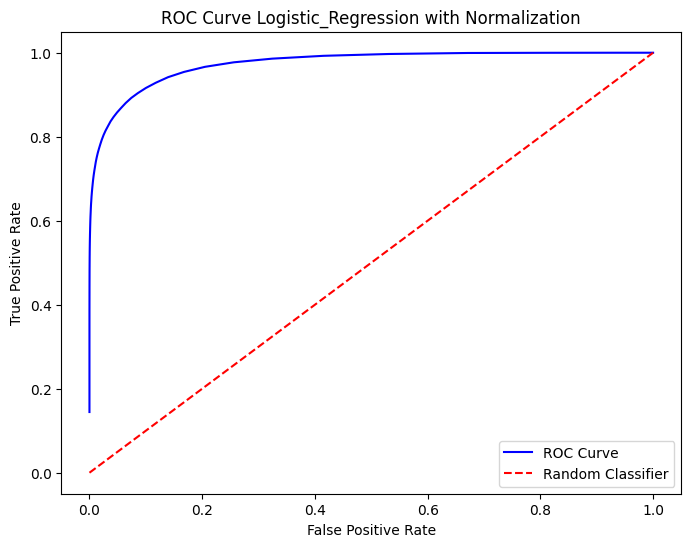

Confusion Matrix and metrics with Normalization:
                  Predicted Positive   Predicted Negative
Actual Positive        57677                 45358        
Actual Negative        396                 478878        
Logistic_Regression AUC: 0.9734555531870611
Logistic_Regression F1 Score: 0.9122226991203951
Logistic_Regression Precision: 0.9275807357438357
Logistic_Regression Recall: 0.9214265965320817
Logistic_Regression Accuracy: 0.9214265965320818


In [ ]:
#LOGISTIC REGRESSION Testing
log_reg_predictions = log_reg_model.transform(test_df)
print_metrics(log_reg_predictions, normalized, "Logistic_Regression", evaluator)

**Random Forest**

In [ ]:
#RANDOM FOREST Training
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
#Hyperparameter grid is different for Random Forest
paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.numTrees, [10, 20])  #Number of trees in the forest
                .addGrid(rf.maxDepth, [5, 10, 15])   #Maximum depth of each tree
                .build())

evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC") #ROC -> True positives vs False Positives
#AUC is area under ROC curve, which represents the probability that given a random chosen positive example and a randomly chosen negative example, the classifier will classify the positive higher than the negative
crossval_rf = CrossValidator(estimator=rf,
                                   estimatorParamMaps=paramGrid_rf,
                                   evaluator=evaluator,
                                   numFolds=5)  #Five-fold cross-validation, this splits dataset in five pieces
rf_model = crossval_rf.fit(train_df) #Train and use crossvalidator to find the best model
if normalized == False:
  rf_model.write().overwrite().save("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/rf_model")
else:
  rf_model.write().overwrite().save("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/rf_model_normalized")

In [ ]:
#RANDOM FOREST Loading
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC") #ROC -> True positives vs False Positives #Binary classificator allows us to get only AUC metric
if normalized == True:
  rf_model = CrossValidatorModel.load("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/rf_model_normalized")
else:
  rf_model = CrossValidatorModel.load("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/rf_model")

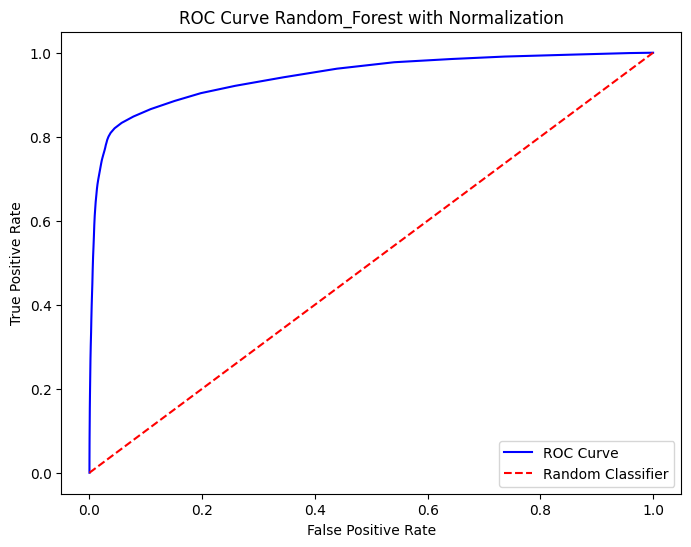

Confusion Matrix and metrics with Normalization:
                  Predicted Positive   Predicted Negative
Actual Positive        41004                 62031        
Actual Negative        1888                 477386        
Random_Forest AUC: 0.9429915733384889
Random_Forest F1 Score: 0.8708519751757811
Random_Forest Precision: 0.8975627726399207
Random_Forest Recall: 0.8902318185018607
Random_Forest Accuracy: 0.8902318185018607


In [ ]:
#RANDOM FOREST Testing
rf_predictions = rf_model.transform(test_df)
print_metrics(rf_predictions, normalized, "Random_Forest", evaluator)

**Gradient Boosted Trees**

In [ ]:
gbt = GBTClassifier(featuresCol="features", labelCol="label")
paramGrid_gbt = (ParamGridBuilder()
                 .addGrid(gbt.maxIter, [10])   # Number of boosting iterations
                 .addGrid(gbt.maxDepth, [10])   # Maximum depth of each tree
                 .build())

evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
crossval_gbt = CrossValidator(estimator=gbt,
                              estimatorParamMaps=paramGrid_gbt,
                              evaluator=evaluator,
                              numFolds=5)
gbt_model = crossval_gbt.fit(train_df)


if normalized == False:
    gbt_model.write().overwrite().save("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/gbt_model")
else:
    gbt_model.write().overwrite().save("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/gbt_model_normalized")


In [ ]:
#GRADIENT BOOSTED TREES Loading
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
if normalized == True:
  gbt_model = CrossValidatorModel.load("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/gbt_model_normalized")
else:
  gbt_model = CrossValidatorModel.load("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/gbt_model")

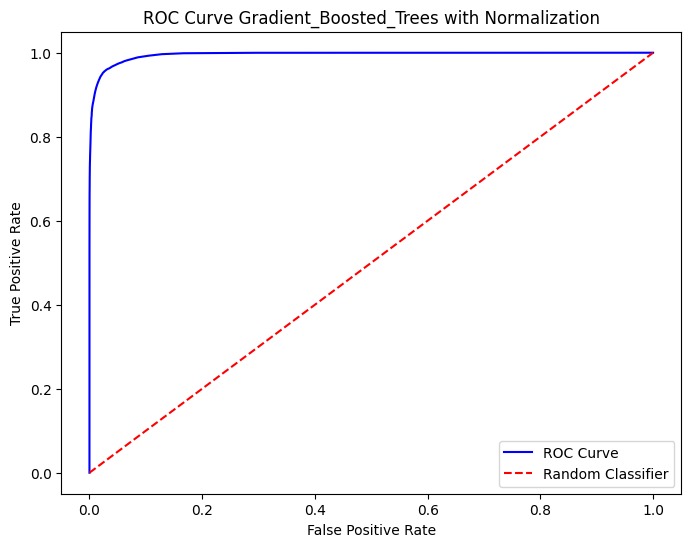

Confusion Matrix and metrics with Normalization:
                  Predicted Positive   Predicted Negative
Actual Positive        92956                 10079        
Actual Negative        4478                 474796        
Gradient_Boosted_Trees AUC: 0.995466829655378
Gradient_Boosted_Trees F1 Score: 0.974724631146911
Gradient_Boosted_Trees Precision: 0.9747591205728366
Gradient_Boosted_Trees Recall: 0.9750012450434391
Gradient_Boosted_Trees Accuracy: 0.9750012450434391


In [ ]:
#GRADIENT BOOSTED TREES Testing
gbt_predictions = gbt_model.transform(test_df)
print_metrics(gbt_predictions, normalized, "Gradient_Boosted_Trees", evaluator)

**Multi-Layer Perceptron**

In [23]:
#MLP Training
mlp = MultilayerPerceptronClassifier(featuresCol="features", labelCol="label")
paramGrid_mlp = (ParamGridBuilder()
                 .addGrid(mlp.stepSize, [0.01])   # Learning Rate
                 .addGrid(mlp.layers, [[784, 32, 2]]) #Number of input neurons, num of neurons in hidden layer, number of output neurons 2 for binary classification
                 .addGrid(mlp.maxIter, [1])   #Max iterations
                 .build())

evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
crossval_mlp = CrossValidator(estimator=mlp,
                              estimatorParamMaps=paramGrid_mlp,
                              evaluator=evaluator,
                              numFolds=5)
mlp_model = crossval_mlp.fit(train_df)


if normalized == False:
    mlp_model.write().overwrite().save("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/mlp_model")
else:
    mlp_model.write().overwrite().save("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/mlp_model_normalized")

In [ ]:
#MLP Loading
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
if normalized == True:
  mlp_model = CrossValidatorModel.load("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/mlp_model_normalized")
else:
  mlp_model = CrossValidatorModel.load("./drive/MyDrive/DATA_MINING/Homework_2_Problem_3/mlp_model")

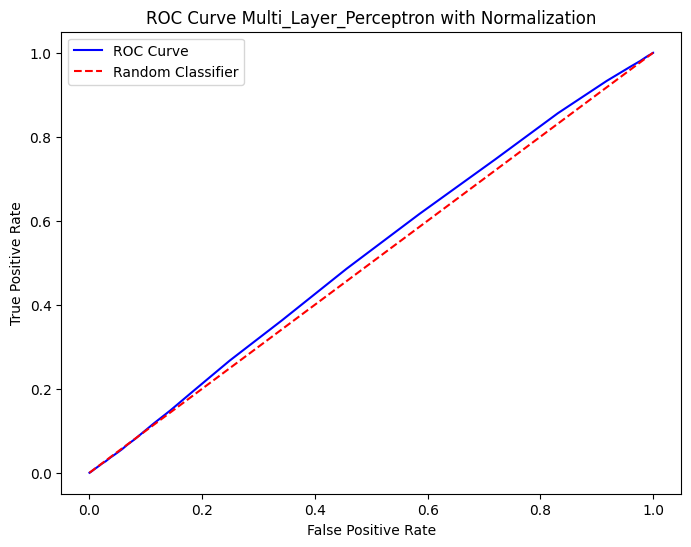

Confusion Matrix and metrics with Normalization:
                  Predicted Positive   Predicted Negative
Actual Positive        228                 102807        
Actual Negative        1325                 477949        
Multi_Layer_Perceptron AUC: 0.4996661053999717
Multi_Layer_Perceptron F1 Score: 0.7429762700859456
Multi_Layer_Perceptron Precision: 0.7033352684988071
Multi_Layer_Perceptron Recall: 0.8211739815115343
Multi_Layer_Perceptron Accuracy: 0.8211739815115342


In [24]:
#MLP Testing
mlp_predictions = mlp_model.transform(test_df)
print_metrics(mlp_predictions, normalized, "Multi_Layer_Perceptron", evaluator)